In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
from exp.nb_fully import *
from torch import nn
import torch.nn.functional as F

## Setup

In [5]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [6]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [7]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m, nh, 10)

In [10]:
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Cross Entropy Loss

In [11]:
def log_softmax(x): return (x.exp() / x.exp().sum(-1, keepdim = True)).log()

In [12]:
sm_pred = log_softmax(pred)

In [13]:
# making mini test dataset
sm_mini = sm_pred[:3]
y_mini = y_train[:3]
sm_mini, y_mini

(tensor([[-2.1999, -2.3271, -2.5865, -2.1925, -2.2744, -2.3894, -2.2109, -2.1753,
          -2.5732, -2.2012],
         [-2.2970, -2.3666, -2.4883, -2.2279, -2.1878, -2.3383, -2.2442, -2.1697,
          -2.4648, -2.2933],
         [-2.4119, -2.4485, -2.4297, -2.2451, -2.2447, -2.4398, -2.1672, -2.2130,
          -2.3736, -2.1219]], grad_fn=<SliceBackward>), tensor([5, 0, 4]))

In [14]:
sm_mini[[0,1,2], [5,0,4]]

tensor([-2.3894, -2.2970, -2.2447], grad_fn=<IndexBackward>)

In [15]:
def nll(input, target): return -input[range(input.shape[0]),target].mean()

In [16]:
nll(sm_mini, y_mini)

tensor(2.3104, grad_fn=<NegBackward>)

In [17]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim = True).log()

In [18]:
sm_pred_2 = log_softmax(pred)

In [19]:
test_near(sm_pred, sm_pred_2)

True

In [20]:
def logsumexp(x):
    a = x.max(-1)[0].unsqueeze(-1)
    return a + (x-a).exp().sum(-1,keepdim=True).log()

In [21]:
def log_softmax(x):
    return x - logsumexp(x)

In [22]:
test_near(sm_pred, log_softmax(pred))

True

In [23]:
loss = nll(sm_pred, y_train)

In [24]:
test_near(nll(log_softmax(pred), y_train), loss)

True

In [25]:
test_near(F.cross_entropy(pred, y_train), loss)

True

Now we have implemented a pytorch's cross entropy function!!

## Basic Training Loop

In [26]:
loss_func = F.cross_entropy
epochs = 1
lr = 0.5
bs = 64

In [27]:
model = Model(m, nh, 10)

In [41]:
#export
def accuracy(out, yb): return (out.argmax(-1) == yb).float().mean()

In [2]:
xb = x_train[0:bs]
yb = y_train[0:bs]
preds = model(xb)
accuracy(preds, yb)

NameError: name 'x_train' is not defined

In [28]:
for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= lr * l.weight.grad
                        l.bias -= lr * l.bias.grad
                        l.weight.grad.zero_()
                        l.bias  .grad.zero_()

In [29]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2025, grad_fn=<NllLossBackward>), tensor(0.8750))

## Using Parameters and Optim

In [30]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))
        

In [31]:
model = Model(m, nh, 10)
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [32]:
for name,l in model.named_children(): print(f"{name}", l)

l1 Linear(in_features=784, out_features=50, bias=True)
l2 Linear(in_features=50, out_features=10, bias=True)


In [33]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [34]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= lr * p.grad
                model.zero_grad()
                    

In [35]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0830, grad_fn=<NllLossBackward>), tensor(1.))

## Registering Modules

In [36]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [37]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(layers): self.add_module(f'layer{i}', l)
    def __call__(self, x):
        for l in layers: x = l(x)
        return x

In [38]:
model = Model(layers)

In [39]:
model

Model(
  (layer0): Linear(in_features=784, out_features=50, bias=True)
  (layer1): ReLU()
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

In [40]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    def __call__(self, x):
        for l in layers: x = l(x)
        return x

In [41]:
model = Model(layers)

In [42]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [43]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0643, grad_fn=<NllLossBackward>), tensor(1.))

## nn.Sequential

In [44]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.3077, grad_fn=<NllLossBackward>), tensor(0.9375))

In [45]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## Optim

In [47]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [48]:
opt = Optimizer(model.parameters())

In [49]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
                    

In [50]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0593, grad_fn=<NllLossBackward>), tensor(1.))

In [51]:
from torch import optim

In [52]:
optim.SGD.step??

In [53]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [55]:
model, opt = get_model()
model, opt

(Sequential(
   (0): Linear(in_features=784, out_features=50, bias=True)
   (1): ReLU()
   (2): Linear(in_features=50, out_features=10, bias=True)
 ), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.5
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [56]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
                    

In [57]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1302, grad_fn=<NllLossBackward>), tensor(0.9375))

## Dataset Class

In [30]:
#export
class Dataset():
    def __init__(self, x, y): self.x, self.y= x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [196]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

In [73]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb,yb = train_ds[i*bs : i*bs+bs]
            preds = model(xb)
            loss = loss_func(preds, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
                    

In [74]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1899, grad_fn=<NllLossBackward>), tensor(0.9375))

## Dataloader Class

In [28]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds),self.bs): yield self.ds[i:i+self.bs]

In [29]:
train_dl = DataLoader(train_ds, bs)

NameError: name 'train_ds' is not defined

In [98]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
                    

In [99]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1608, grad_fn=<NllLossBackward>), tensor(0.9375))

## Random Sampling

In [31]:
#export
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds), bs, shuffle
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [139]:
small_ds = Dataset(*train_ds[:10])

In [140]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [141]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([9, 5, 4]), tensor([7, 1, 8]), tensor([2, 3, 6]), tensor([0])]

In [32]:
#export
class DataLoader():
    def __init__(self, ds, s): self.ds, self.s = ds,s
    def __iter__(self):
        for idxs in self.s:
            yield self.ds[idxs]

In [188]:
s = Sampler(train_ds, 64, True)
train_dl = DataLoader(train_ds, s)

In [189]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
                    

In [190]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1613, grad_fn=<NllLossBackward>), tensor(0.9375))

In [197]:
train_samp = Sampler(train_ds, 64, True)
valid_samp = Sampler(valid_ds, 64, False)

In [199]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

tensor(3)

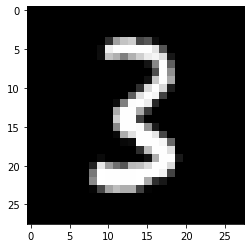

In [206]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28), cmap='gray')
yb[0]

tensor(0)

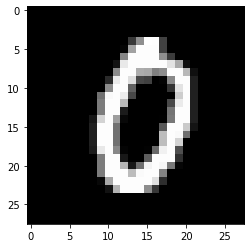

In [213]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28), cmap='gray')
yb[0]

## PyTorch Dataloader

In [214]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [215]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [216]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [217]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.4243, grad_fn=<NllLossBackward>), tensor(0.9062))

In [218]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [219]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3281, grad_fn=<NllLossBackward>), tensor(0.9062))

In [265]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
            nv = len(valid_dl)
            print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [266]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [267]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1475) tensor(0.9548)
1 tensor(0.2956) tensor(0.9091)
2 tensor(0.1172) tensor(0.9666)
3 tensor(0.1255) tensor(0.9620)
4 tensor(0.1084) tensor(0.9688)


In [46]:
!python nb2script.py minibatch_training.ipynb

Converted minibatch_training.ipynb to exp/nb_minibatch.py


In [47]:
!cat exp/nb_minibatch.py


#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/minibatch_training.ipynb

def accuracy(out, yb): return (out.argmax(-1) == yb).float().mean()

class Dataset():
    def __init__(self, x, y): self.x, self.y= x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds), bs, shuffle
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

class DataLoader():
    def __init__(self, ds, s): self.ds, self.s = ds,s
    def __iter__(self):
        for idxs in self.s:
            yield self.ds[idxs]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_dls(train_ds, v